In [3]:
import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, GroupKFold, TimeSeriesSplit, BaseCrossValidator, KFold, ParameterGrid
from sklearn.exceptions import NotFittedError
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.metrics import get_scorer
from typing import Optional, List, Any, Dict, Iterator, Tuple
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

class GroupTimeSeriesSplit(BaseCrossValidator):
    """
    Cross-validator for panel data that is both group-aware and time-aware.
    For each group, it performs time series split, and aggregates the splits across all groups.
    """

    def __init__(self, n_splits: int = 5, group_col: str = 'group', time_col: str = 'time'):
        self.n_splits = n_splits
        self.group_col = group_col
        self.time_col = time_col

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        """
        Yield train and test indices for each fold, aggregating across all groups.

        For each fold, the test indices consist of the test splits from each group.
        Similarly, the train indices consist of the train splits from each group.
        """
        X = pd.DataFrame(X)
        unique_groups = X[self.group_col].unique()

        # Initialize a dictionary to hold split generators for each group
        split_generators = {}

        for group in unique_groups:
            X_group = X[X[self.group_col] == group].sort_values(self.time_col)
            n_samples = X_group.shape[0]
            if n_samples < self.n_splits + 1:
                warnings.warn(f"Not enough samples in group '{group}' for {self.n_splits} splits. Skipping this group.")
                continue
            tscv = TimeSeriesSplit(n_splits=self.n_splits)
            split_generators[group] = tscv.split(X_group)

        for fold in range(self.n_splits):
            train_indices = set()
            test_indices = set()
            for group in unique_groups:
                try:
                    group_train_idx, group_test_idx = next(split_generators[group])
                    # Get the actual indices from the original DataFrame
                    group_full = X[X[self.group_col] == group].sort_values(self.time_col)
                    group_train_indices = group_full.iloc[group_train_idx].index
                    group_test_indices = group_full.iloc[group_test_idx].index
                    train_indices.update(group_train_indices)
                    test_indices.update(group_test_indices)
                except StopIteration:
                    warnings.warn(f"Group '{group}' does not have enough splits.")
            yield list(train_indices), list(test_indices)

class PanelDataGridSearchCV:
    def __init__(
        self,
        estimator,
        param_grid: Dict[str, List[Any]],
        group_col: Optional[str] = None,
        time_col: Optional[str] = None,
        exclude_cols: Optional[List[str]] = None,
        cv: int = 5,
        scoring: Optional[str] = None,
        n_jobs: Optional[int] = None,
        verbose: int = 0,
        **kwargs
    ):
        """
        Initializes the PanelDataGridSearchCV.

        :param estimator: The machine learning estimator (e.g., RandomForestRegressor).
        :param param_grid: Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values.
        :param group_col: The name of the column representing groups in the panel data.
        :param time_col: The name of the column representing time in the panel data. If provided, time-aware splitting is performed.
        :param exclude_cols: List of additional columns to exclude from features.
        :param cv: Number of cross-validation folds.
        :param scoring: A string or callable to evaluate the predictions on the test set.
        :param n_jobs: Number of jobs to run in parallel.
        :param verbose: Controls the verbosity: the higher, the more messages.
        :param kwargs: Additional arguments for GridSearchCV.
        """
        self.estimator = estimator
        self.param_grid = param_grid
        self.group_col = group_col
        self.time_col = time_col
        self.exclude_cols = exclude_cols if exclude_cols is not None else []
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.kwargs = kwargs
        self.grid_search = None
        self.best_estimator_ = None
        self.best_params_ = None
        self.best_score_ = None
        self.cv_splitter = None  # To store the cross-validator after fitting
        self.X_fit_ = None
        self.y_fit_ = None
        self.groups_ = None  # To store groups if group-aware only

    def _create_cv_splitter(self, X: pd.DataFrame) -> Any:
        if self.group_col and self.time_col:
            # Both group-aware and time-aware
            cv_splitter = GroupTimeSeriesSplit(n_splits=self.cv, group_col=self.group_col, time_col=self.time_col)
        elif self.group_col:
            # Group-aware only
            cv_splitter = GroupKFold(n_splits=self.cv)
        elif self.time_col:
            # Time-aware only
            # Assuming data is sorted by time
            cv_splitter = TimeSeriesSplit(n_splits=self.cv)
        else:
            # Regular KFold
            cv_splitter = KFold(n_splits=self.cv, shuffle=False)
        return cv_splitter

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Fit the GridSearchCV on the panel data.

        :param X: Feature dataframe.
        :param y: Target series.
        :return: self
        """
        X = X.copy()
        y = y.copy()
        if self.group_col and self.group_col not in X.columns:
            raise ValueError(f"Group column '{self.group_col}' not found in the dataframe.")
        if self.time_col and self.time_col not in X.columns:
            raise ValueError(f"Time column '{self.time_col}' not found in the dataframe.")

        if self.time_col:
            # Sort data by group and time
            sort_columns = [self.group_col, self.time_col] if self.group_col else [self.time_col]
            X.sort_values(by=sort_columns, inplace=True)
            y = y.loc[X.index]

        # Store X and y for visualization
        self.X_fit_ = X
        self.y_fit_ = y

        # Determine columns to exclude from features
        # When both group_col and time_col are set, exclude them
        # They are needed for splitting but should be excluded from features
        # Hence, use a pipeline to drop them before passing to the estimator

        def drop_columns(X):
            exclude = self.exclude_cols.copy()
            if self.group_col and not self.time_col:
                exclude.append(self.group_col)
            if self.time_col and not self.group_col:
                exclude.append(self.time_col)
            if self.group_col and self.time_col:
                exclude.extend([self.group_col, self.time_col])
            return X.drop(columns=exclude, errors='ignore')

        preprocessor = FunctionTransformer(drop_columns, validate=False)

        # Create a pipeline that first drops the necessary columns, then fits the estimator
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('estimator', clone(self.estimator))
        ])

        # Create the cross-validator
        cv_splitter = self._create_cv_splitter(X)
        self.cv_splitter = cv_splitter  # Store for visualization

        if self.group_col and not self.time_col:
            groups = X[self.group_col]
            self.groups_ = groups  # Store groups for visualization
        elif self.group_col and self.time_col:
            groups = None  # GroupTimeSeriesSplit handles groups internally
        else:
            groups = None

        # Adjust parameter grid keys to align with pipeline steps
        # Assuming parameters are specified with 'estimator__' prefix
        adjusted_param_grid = self.param_grid

        self.grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            cv=cv_splitter,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            verbose=self.verbose,
            error_score='raise',  # Raise errors immediately for easier debugging
            **self.kwargs
        )

        # Fit GridSearchCV on the full data (with 'group' and 'time' if both are set)
        self.grid_search.fit(X, y, groups=groups)
        self.best_estimator_ = self.grid_search.best_estimator_
        self.best_params_ = self.grid_search.best_params_
        self.best_score_ = self.grid_search.best_score_
        return self

    def predict(self, X: pd.DataFrame):
        """
        Predict using the best estimator.

        :param X: Feature dataframe.
        :return: Predictions.
        """
        if self.best_estimator_ is None:
            raise NotFittedError("This PanelDataGridSearchCV instance is not fitted yet.")

        return self.best_estimator_.predict(X)

    def score(self, X: pd.DataFrame, y: pd.Series):
        """
        Score using the best estimator.

        :param X: Feature dataframe.
        :param y: Target series.
        :return: Score.
        """
        if self.best_estimator_ is None:
            raise NotFittedError("This PanelDataGridSearchCV instance is not fitted yet.")

        return self.best_estimator_.score(X, y)

    def get_cv_results(self):
        """
        Get cross-validation results from the grid search.

        :return: cv_results_ dictionary.
        """
        if self.grid_search is None:
            raise NotFittedError("This PanelDataGridSearchCV instance is not fitted yet.")
        return self.grid_search.cv_results_

    def get_best_params(self):
        """
        Get the best parameters found during the grid search.

        :return: Best parameters dictionary.
        """
        return self.best_params_

    def get_best_score(self):
        """
        Get the best score achieved during the grid search.

        :return: Best score.
        """
        return self.best_score_

    def plot_splits(self):
        """
        Visualize the cross-validation splits.

        - Group-Aware: Shows which groups are in each fold.
        - Time-Aware: Shows train/test split over time.
        - Both: Shows split per group over time.

        Requires matplotlib and seaborn.
        """
        if self.cv_splitter is None:
            raise NotFittedError("This PanelDataGridSearchCV instance is not fitted yet.")

        if self.X_fit_ is None or self.y_fit_ is None:
            raise AttributeError("X_fit_ and y_fit_ attributes not found. Ensure that the fit method has been called.")

        X_fit = self.X_fit_
        y_fit = self.y_fit_

        # Extract the splits
        if self.group_col and not self.time_col:
            # Group-aware only, need to pass 'groups'
            if self.groups_ is None:
                raise AttributeError("groups_ attribute not found. Ensure that the fit method has been called with group_col.")
            cv_splits = list(self.cv_splitter.split(X_fit, y_fit, self.groups_))
        else:
            # For other scenarios, 'groups' are either handled internally or not needed
            cv_splits = list(self.cv_splitter.split(X_fit, y_fit))

        num_folds = len(cv_splits)
        if num_folds == 0:
            raise ValueError("No splits were generated by the cross-validator.")

        plt.figure(figsize=(12, 6))
        if self.group_col and self.time_col:
            # Both group-aware and time-aware
            unique_groups = X_fit[self.group_col].unique()
            num_groups = len(unique_groups)
            palette = sns.color_palette("hsv", num_groups)
            group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

            # Initialize y-axis positions for each group
            group_positions = {group: i for i, group in enumerate(unique_groups)}
            y_offsets = np.arange(num_groups)  # Positions for each group on y-axis

            for fold, (train_idx, test_idx) in enumerate(cv_splits):
                # For each group, plot train and test splits
                for group in unique_groups:
                    group_data = X_fit[X_fit[self.group_col] == group].sort_values(self.time_col)
                    time = group_data[self.time_col]
                    indices = group_data.index
                    train_indices_group = set(train_idx).intersection(indices)
                    test_indices_group = set(test_idx).intersection(indices)

                    # Plot train indices
                    plt.scatter(time[group_data.index.isin(train_indices_group)],
                                [group_positions[group]] * len(train_indices_group),
                                color=group_colors[group],
                                alpha=0.3,
                                marker='o',
                                label='Train' if (fold == 0 and group == unique_groups[0]) else "")

                    # Plot test indices
                    plt.scatter(time[group_data.index.isin(test_indices_group)],
                                [group_positions[group]] * len(test_indices_group),
                                color=group_colors[group],
                                alpha=0.6,
                                marker='x',
                                label='Test' if (fold == 0 and group == unique_groups[0]) else "")
            plt.yticks(y_offsets, unique_groups)
            plt.xlabel('Time')
            plt.ylabel('Group')
            plt.title('Group and Time-Aware Cross-Validation Splits')

            # Create custom legends
            group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
            train_patch = mpatches.Patch(color='gray', alpha=0.3, label='Train')
            test_patch = mpatches.Patch(color='gray', alpha=0.6, label='Test')
            plt.legend(handles=group_patches + [train_patch, test_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

        elif self.group_col:
            # Group-aware only
            unique_groups = X_fit[self.group_col].unique()
            palette = sns.color_palette("hsv", len(unique_groups))
            group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

            # Assign each group to a fold
            cv_splitter = self.cv_splitter
            fold_assignments = {fold: [] for fold in range(self.cv)}
            for fold, (train_idx, test_idx) in enumerate(cv_splitter.split(X_fit, self.y_fit_, self.groups_)):
                test_groups = X_fit.iloc[test_idx][self.group_col].unique()
                fold_assignments[fold].extend(test_groups)

            # Plot each group and its fold
            group_fold = []
            for group in unique_groups:
                assigned_fold = None
                for fold, groups in fold_assignments.items():
                    if group in groups:
                        assigned_fold = fold + 1  # 1-based indexing for folds
                        break
                group_fold.append(assigned_fold)

            df_plot = pd.DataFrame({
                'Group': unique_groups,
                'Fold': group_fold
            })

            sns.barplot(x='Group', y='Fold', data=df_plot, hue='Group', dodge=False, palette=palette, legend=False)
            plt.xlabel('Group')
            plt.ylabel('Fold')
            plt.title('Group-Aware Cross-Validation Splits')

            # Create custom legends
            group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
            plt.legend(handles=group_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

        elif self.time_col:
            # Time-aware only
            plt.title('Time-Aware Cross-Validation Splits')
            for fold, (train_idx, test_idx) in enumerate(cv_splits):
                train_time = X_fit.iloc[train_idx][self.time_col]
                test_time = X_fit.iloc[test_idx][self.time_col]
                plt.plot(train_time, [fold + 1] * len(train_time), 'b.', label='Train' if fold == 0 else "")
                plt.plot(test_time, [fold + 1] * len(test_time), 'r.', label='Test' if fold == 0 else "")
            plt.xlabel('Time')
            plt.ylabel('Fold')
            plt.yticks(range(1, self.cv + 1))
            plt.legend()

        else:
            # Regular KFold
            plt.title('K-Fold Cross-Validation Splits')
            for fold, (train_idx, test_idx) in enumerate(cv_splits):
                plt.scatter(train_idx, [fold + 1] * len(train_idx), marker='o', label='Train' if fold == 0 else "", alpha=0.6)
                plt.scatter(test_idx, [fold + 1] * len(test_idx), marker='x', label='Test' if fold == 0 else "", alpha=0.6)
            plt.xlabel('Sample Index')
            plt.ylabel('Fold')
            plt.yticks(range(1, self.cv + 1))
            plt.legend()

        plt.tight_layout()
        plt.show()


=== Group-Aware Splitting ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'estimator__max_depth': None, 'estimator__n_estimators': 100}
Best Score: 0.7561141890195072


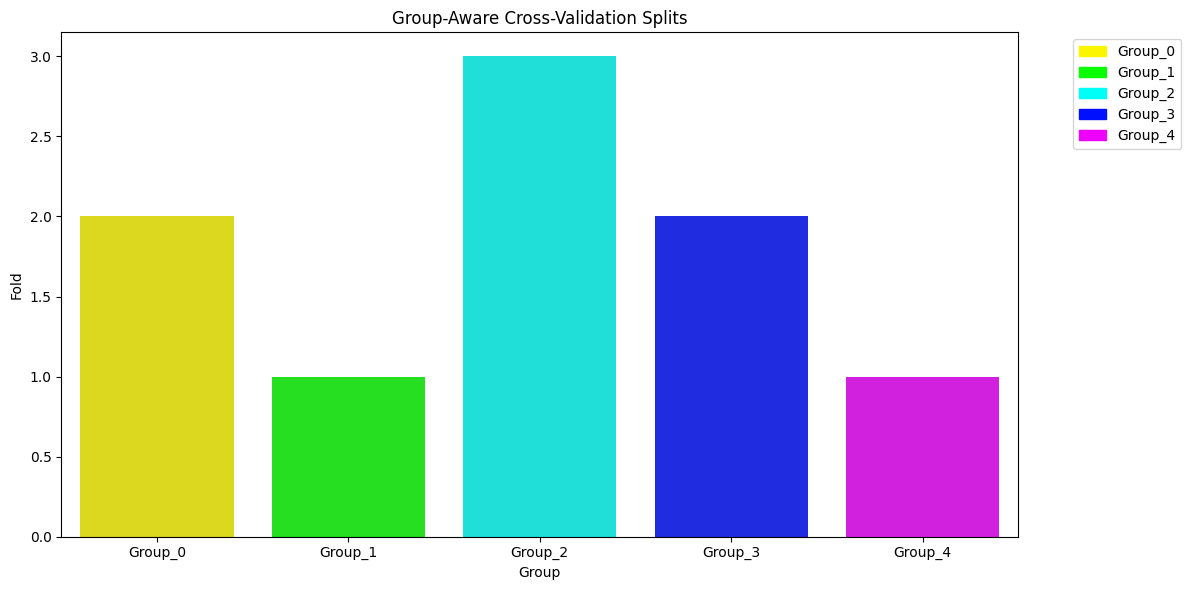


=== Time-Aware Splitting ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'estimator__max_depth': None, 'estimator__n_estimators': 50}
Best Score: 0.5557732515881015


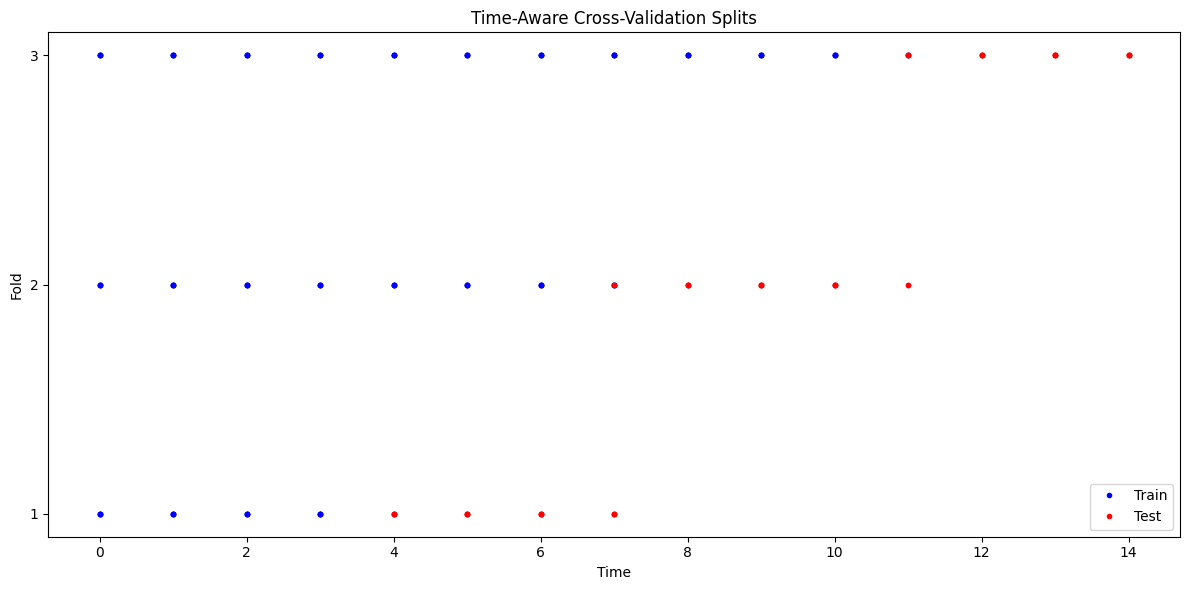


=== Group and Time-Aware Splitting ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'estimator__max_depth': None, 'estimator__n_estimators': 50}
Best Score: 0.695212491205345


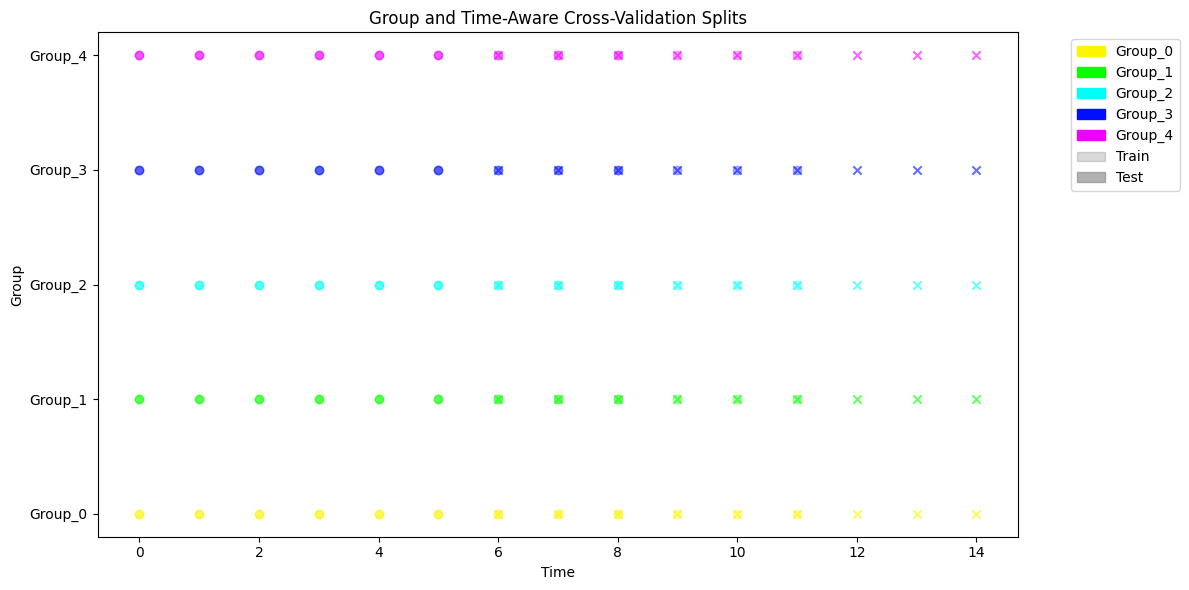

Predictions: [-114.34674246  -44.50947676  141.90199759 -140.853718     63.36531963]


In [4]:
if __name__ == "__main__":
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import make_regression

    # Create a sample panel dataset
    np.random.seed(42)
    num_groups = 5
    num_timepoints = 15
    total_samples = num_groups * num_timepoints

    groups = np.repeat([f'Group_{i}' for i in range(num_groups)], num_timepoints)
    time = list(range(num_timepoints)) * num_groups
    X_features, y = make_regression(n_samples=total_samples, n_features=5, noise=0.1)

    df = pd.DataFrame(X_features, columns=[f'feature_{i}' for i in range(5)])
    df['group'] = groups
    df['time'] = time
    y = pd.Series(y, name='target')

    # Initialize the estimator and parameter grid
    estimator = RandomForestRegressor(random_state=42)
    param_grid = {
        'estimator__n_estimators': [50, 100],
        'estimator__max_depth': [None, 10, 20]
    }

    # Scenario 1: Group-Aware Splitting
    print("\n=== Group-Aware Splitting ===")
    panel_cv_group = PanelDataGridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        group_col='group',
        time_col=None,  # Not time-aware
        exclude_cols=[],  # No additional columns to exclude
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    panel_cv_group.fit(df, y)

    # Output the best parameters and score
    print("Best Parameters:", panel_cv_group.get_best_params())
    print("Best Score:", panel_cv_group.get_best_score())

    # Visualize the splits
    panel_cv_group.plot_splits()

    # Scenario 2: Time-Aware Splitting
    print("\n=== Time-Aware Splitting ===")
    # To prevent the 'group' column from being included as a feature, we specify it in exclude_cols
    panel_cv_time = PanelDataGridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        group_col=None,  # Not group-aware
        time_col='time',  # Time-aware
        exclude_cols=['group'],  # Exclude 'group' column from features
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    panel_cv_time.fit(df, y)

    # Output the best parameters and score
    print("Best Parameters:", panel_cv_time.get_best_params())
    print("Best Score:", panel_cv_time.get_best_score())

    # Visualize the splits
    panel_cv_time.plot_splits()

    # Scenario 3: Both Group-Aware and Time-Aware Splitting
    print("\n=== Group and Time-Aware Splitting ===")
    panel_cv_both = PanelDataGridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        group_col='group',
        time_col='time',
        exclude_cols=[],  # No additional columns to exclude
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    try:
        panel_cv_both.fit(df, y)
    except ValueError as e:
        print("Error during fitting Scenario 3:", e)
    else:
        # Output the best parameters and score
        print("Best Parameters:", panel_cv_both.get_best_params())
        print("Best Score:", panel_cv_both.get_best_score())

        # Visualize the splits
        panel_cv_both.plot_splits()

        # Make predictions
        try:
            predictions = panel_cv_both.predict(df)
            print("Predictions:", predictions[:5])
        except NotFittedError as e:
            print(e)